In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import (
    generate_test_data,
    generate_train_data,
    show_plot,
    train_model,
    uncertainty_estimation,
    enable_dropout_test,
    transfer_weights
)
from models import (
    LinearNet,
    ZigZagNet,
    ZigZigNet,
    PackedNet,
    SVINet,
    SWAG,
    VBLLNet
)

import torch

import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'DeJavu Serif'
# plt.rcParams['font.serif'] = ['Times New Roman']

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

/opt/conda/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


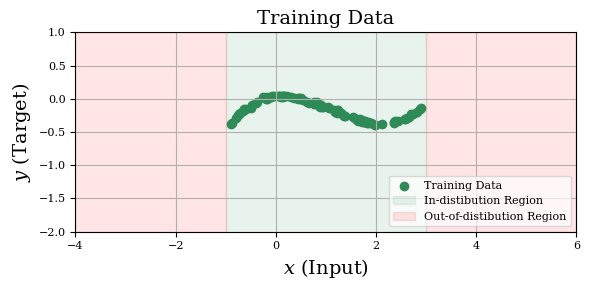

In [74]:
X_data, Y_data = generate_train_data(100)
Xt = generate_test_data()
show_plot(X_data, Y_data, save_name="dataset")

### Zig-Zag (2-step inference)

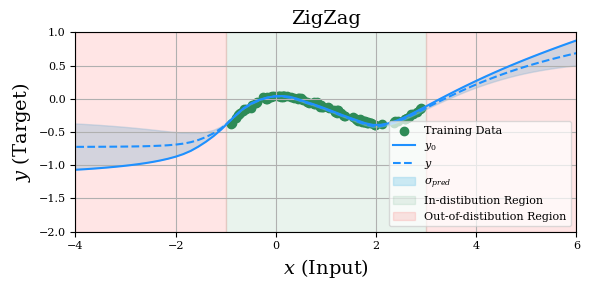

In [81]:
net_zz = ZigZagNet(hidden_layer=8)
net_zz = train_model(net_zz, X_data, Y_data)
net_zz.eval()
Y_1 = net_zz(Xt).detach()
Y_2 = net_zz(Xt, Y_1).detach()

show_plot(X_data, Y_data, Xt=Xt, Y_pred=Y_2, Y_pred0=Y_1, error=uncertainty_estimation([Y_1,Y_2]), plot_title="ZigZag", save_name="ZigZag")

### Ensemble (Multiple Preds)

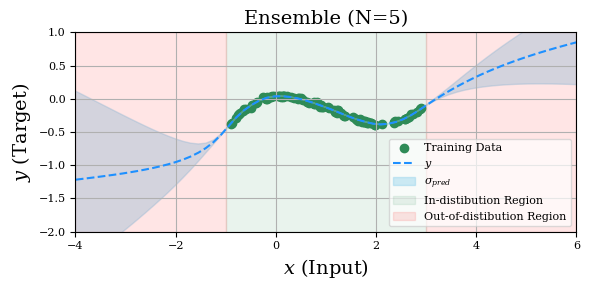

In [91]:
def eval_linear(X_data, Y_data, Xt, hidden_layer=8):
    model = LinearNet(hidden_layer=hidden_layer,) 
    model = train_model(model, X_data, Y_data, model_type="linear")
    model.eval()
    return model(Xt)

ensemble_preds =[eval_linear(X_data, Y_data, Xt).detach() for _ in range(5)] 
y_m = torch.stack(ensemble_preds).mean(dim=0)
show_plot(X_data, Y_data, Xt=Xt, Y_pred=y_m.detach(), error=uncertainty_estimation(ensemble_preds), plot_title="Ensemble (N=5)", save_name="ensemble")

### MC-Dropout (Sampling N=5)

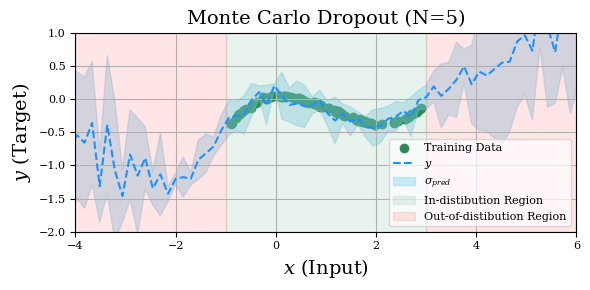

In [92]:
model = LinearNet(hidden_layer=8) 
model = train_model(model, X_data, Y_data, model_type="linear")

model.eval()
model = enable_dropout_test(model)

preds = [model(Xt) for _ in range(5)]
preds = [x.detach() for x in preds]
y_m = torch.stack(preds).mean(dim=0)
show_plot(X_data, Y_data, Xt=Xt, Y_pred=y_m.detach(), error=uncertainty_estimation(preds), plot_title="Monte Carlo Dropout (N=5)", save_name="mc-dropout")

### Packed Ensemble - Last Layer (deterministic)

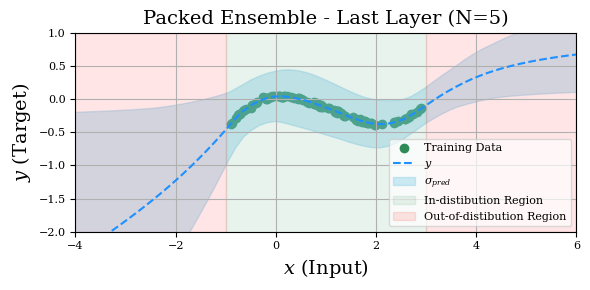

In [93]:
net_packed = PackedNet(hidden_layer=8)
net_packed = train_model(net_packed, X_data, Y_data, model_type="packed")
net_packed.eval()
pred = net_packed(Xt)

show_plot(X_data, Y_data, Xt=Xt, Y_pred=pred.mean(dim=1).detach(),
          error=uncertainty_estimation([pred[:,x,:].detach() for x in range(5)]), 
          plot_title="Packed Ensemble - Last Layer (N=5)", save_name="pe_ll")

### Stochastic Variational Inference - Last Layer (sampling)

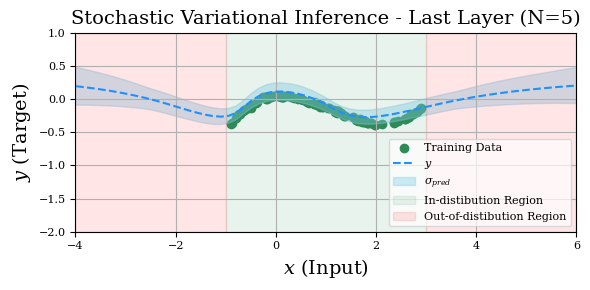

In [113]:
net_SVI = SVINet(hidden_layer=8)
net_SVI = train_model(net_SVI, X_data, Y_data, model_type="svi")
net_SVI.eval()
preds = [net_SVI(Xt)[0].detach() for _ in range(5)]
y_m = torch.stack(preds).mean(dim=0)
show_plot(X_data, Y_data, Xt=Xt, Y_pred=y_m.detach(),
          error=uncertainty_estimation(preds),
          plot_title="Stochastic Variational Inference - Last Layer (N=5)", save_name="svi_ll")

### Stochastic Weight Averaging (N=5)

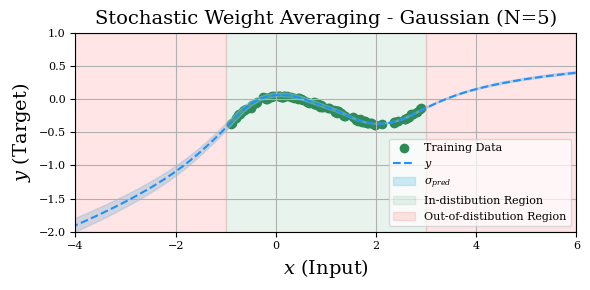

In [115]:
kwargs = {"hidden_layer":8}
model = LinearNet(**kwargs)
swag_model = SWAG(LinearNet,no_cov_mat=False, max_num_models=25, **kwargs)
model, swag_model = train_model(model, X_data, Y_data, model_type="swag", swag_model=swag_model)

swag_model.eval()
preds = []
for _ in range(5):
    swag_model.sample()
    preds.append(swag_model(Xt).detach())
y_m = torch.stack(preds).mean(dim=0)
show_plot(X_data, Y_data, Xt=Xt, Y_pred=y_m.detach(), error=uncertainty_estimation(preds),
         plot_title="Stochastic Weight Averaging - Gaussian (N=5)", save_name="swag")

### Variational Bayes Last Layer (Deterministic)

In [116]:
model = VBLLNet(hidden_layer=8)
model = train_model(model, X_data, Y_data, model_type="vbll")
model.eval()

Y_pred = model(Xt).predictive
Y_mean = Y_pred.mean.detach().numpy().squeeze()
Y_stdev = torch.sqrt(Y_pred.covariance.squeeze()).detach().numpy()

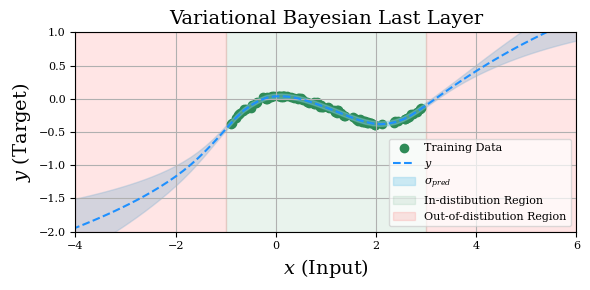

In [118]:
show_plot(X_data, Y_data, Xt=Xt, Y_pred=Y_mean, error=Y_stdev, plot_title="Variational Bayesian Last Layer", save_name="vbll")

In [119]:
model = VBLLNet(hidden_layer=8, kl_penalty=10)
model = train_model(model, X_data, Y_data, model_type="vbll")
model.eval()

Y_pred = model(Xt).predictive
Y_mean = Y_pred.mean.detach().numpy().squeeze()
Y_stdev = torch.sqrt(Y_pred.covariance.squeeze()).detach().numpy()

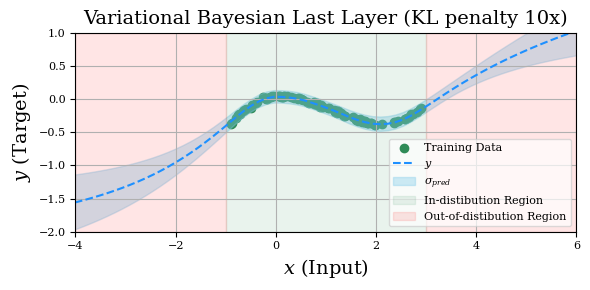

In [120]:
show_plot(X_data, Y_data, Xt=Xt, Y_pred=Y_mean, error=Y_stdev, plot_title="Variational Bayesian Last Layer (KL penalty 10x)")